In [ ]:
import torch
import matplotlib.pyplot as plt
#dire = '/users/local/vincent/'
dire = '../features/'
import numpy as np
from tqdm import tqdm
import tikzplotlib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
baseline_features = torch.load(dire + 'full1')#,map_location = device)

In [3]:
def sphering(features):
    #print('s',features.shape)
    return features / torch.norm(features, p = 2, dim = 2, keepdim = True)

def centering(train_features, features):
    #print('c',features.shape)
    return features - train_features.reshape(-1, train_features.shape[2]).mean(dim = 0).unsqueeze(0).unsqueeze(0)

def preprocess(train_features, features):
    #print('pre',features.shape)
    return sphering(centering(train_features,features))

baseline_features_pe = preprocess(baseline_features[:64], baseline_features)

In [4]:
file = 'f01'
feat = torch.load(dire + file, map_location=device)
feat_pe = preprocess(feat[:63], feat)
print(feat.shape,feat_pe.shape)

torch.Size([99, 600, 640]) torch.Size([99, 600, 640])


In [5]:
def SNR(distrib_1 , distrib_2):
    m1, m2 = torch.mean(distrib_1,dim=0),torch.mean(distrib_2,dim=0)
    std1, std2 = torch.sqrt((torch.std(distrib_1,dim=0)**2).sum()),torch.sqrt((torch.std(distrib_2,dim=0)**2).sum())
    marge = torch.sqrt((abs(m1-m2)**2).sum())
    sig = (std1+std2)
    #print(marge/sig)
    return (2*marge/sig).item()

In [6]:
def compute_SNRmatrix(features, complete=False):
    
    nb_novel = 20
    if complete:
        snr = np.zeros((nb_novel ,nb_novel,3 ))
    else:
        
        snr = np.zeros((nb_novel ,nb_novel ))
    for i in range(nb_novel ):
        for j in range(nb_novel):
            #baseline_SNR[i,j] = SNR(baseline_features[i] ,baseline_features[j])
            if complete:
                snr[i,j] = SNR_complet(features[i] ,features[j])
            else:
                
                snr[i,j] = SNR(features[i] ,features[j])
    return snr

In [7]:
baseline_SNR = compute_SNRmatrix(baseline_features[-20:])
baseline_SNR_pe = compute_SNRmatrix(baseline_features_pe[-20:])

In [8]:
L=[]
L_pe = []
import time
for k in tqdm(range(0,64)):
    file = 'f'+str(k)+'1'
    feat = torch.load(dire + file, map_location=device)
    feat_pe = preprocess(feat[:63], feat)
    features = feat[-20:]
    features_pe = feat_pe[-20:]
    L.append(compute_SNRmatrix(features))
    L_pe.append(compute_SNRmatrix(features_pe))
snr64 = np.array(L)
snr64_pe = np.array(L_pe)

100%|█████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.77it/s]


In [10]:
boost = snr64 - baseline_SNR
boost_pe = snr64_pe - baseline_SNR_pe


In [11]:
np.save('../data/boost_snr.npy', boost_pe)

In [12]:
max_boost =  boost.max(axis = 0)
min_boost =  boost.min(axis = 0)
argmax_boost =  boost.argmax(axis = 0)
argmin_boost =  boost.argmin(axis = 0)
max_boost_pe =  boost_pe.max(axis = 0)
min_boost_pe =  boost_pe.min(axis = 0)
argmax_boost_pe =  boost_pe.argmax(axis = 0)
argmin_boost_pe =  boost_pe.argmin(axis = 0)

Text(0.5, 1.0, 'best base class SNR')

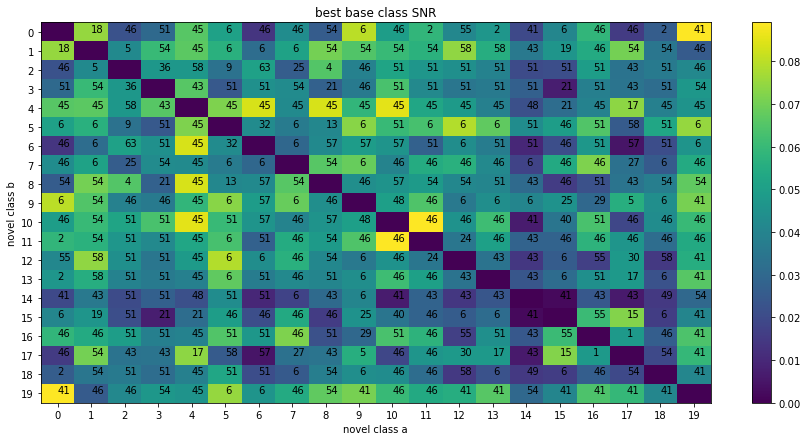

In [13]:
plt.figure(figsize=(15,7))
nb_novel = 20
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(max_boost,aspect='auto')
nb_novel = 20
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k,l,str(argmax_boost[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
plt.title('best base class SNR')

Text(0.5, 1.0, 'worst base class SNR')

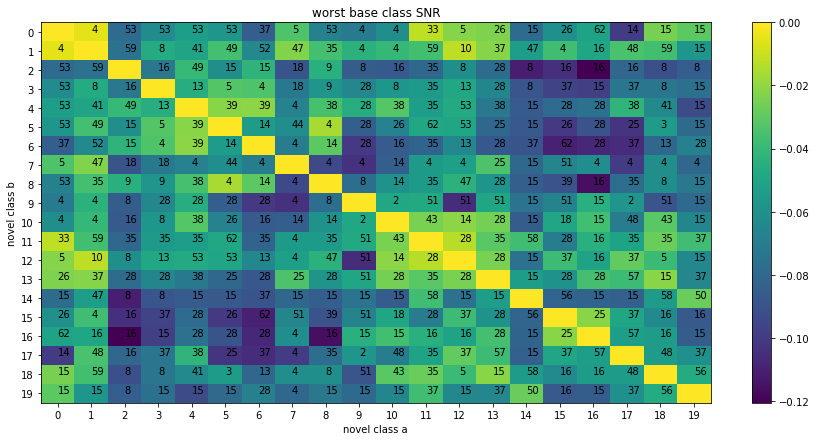

In [14]:
plt.figure(figsize=(15,7))
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(min_boost,aspect='auto')
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l: 
            plt.text(k,l,str(argmin_boost[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
plt.title('worst base class SNR')

Text(0.5, 1, 'best base class SNR')

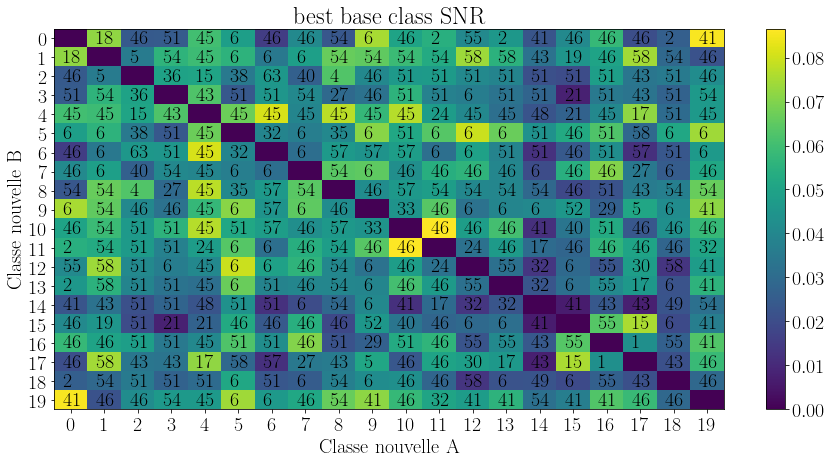

In [16]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(max_boost_pe,aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmax_boost_pe[k,l]))
plt.colorbar()
plt.xlabel('Classe nouvelle A')
plt.ylabel('Classe nouvelle B')
plt.savefig('best_snr.pdf')
plt.title('best base class SNR')

Text(0.5, 1, 'worst base class SNR')

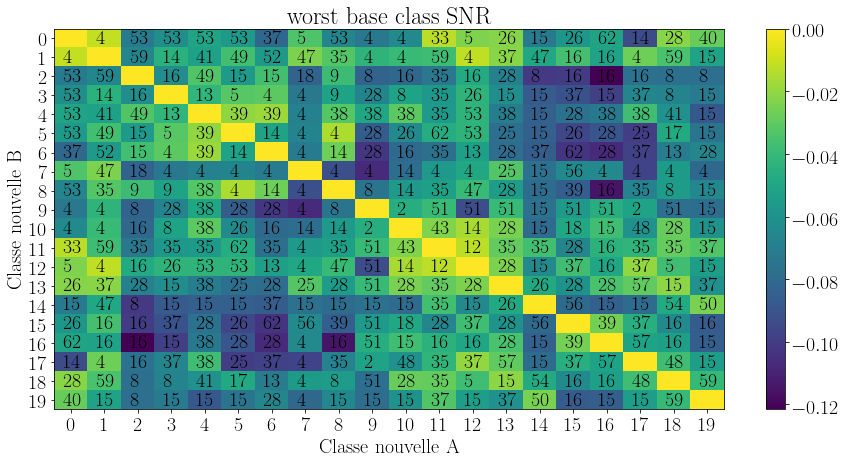

In [17]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(min_boost_pe,aspect='auto')
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l: 
            plt.text(k+shift_x,l+shift_y,str(argmin_boost_pe[k,l]))
plt.colorbar()
plt.xlabel('Classe nouvelle A')
plt.ylabel('Classe nouvelle B')
plt.savefig('worst_snr.pdf')
plt.title('worst base class SNR')

In [18]:
def SNR_complet(distrib_1 , distrib_2):
    m1, m2 = torch.mean(distrib_1,dim=0),torch.mean(distrib_2,dim=0)
    std1, std2 = torch.sqrt((torch.std(distrib_1,dim=0)**2).sum()),torch.sqrt((torch.std(distrib_2,dim=0)**2).sum())
    marge = torch.sqrt((abs(m1-m2)**2).sum())
    sig = (std1+std2)
    return marge, sig, (2*marge/sig).item()

In [19]:
baseline_SNR_full = compute_SNRmatrix(baseline_features[-20:],True)
baseline_SNR_pe_full = compute_SNRmatrix(baseline_features_pe[-20:],True)

In [20]:
L_full=[]
L_full_pe = []
import time
for k in tqdm(range(0,64)):
    file = 'f'+str(k)+'1'
    feat = torch.load(dire + file, map_location=device)
    feat_pe = preprocess(feat[:63], feat)

    features = feat[-20:]
    features_pe = feat_pe[-20:]
    #print(feat.shape,feat_pe.shape,features.shape, features_pe.shape)
    snr = compute_SNRmatrix(features,True)
    snr_full = compute_SNRmatrix(features_pe,True)
    L_full.append(snr)
    L_full_pe.append(snr_full)
    #print(torch.cuda.is_available())
snr64_full = np.array(L_full)
snr64_pe_full = np.array(L_full_pe)

100%|█████████████████████████████████████████████████████████| 64/64 [00:27<00:00,  2.30it/s]


In [21]:
boost_full = snr64_full - baseline_SNR_full
boost_pe_full = snr64_pe_full - baseline_SNR_pe_full

In [22]:
max_boost_full =  boost_full[:,:,:,2].max(axis = 0)
min_boost_full =  boost_full[:,:,:,2].min(axis = 0)
argmax_boost_full =  boost_full[:,:,:,2].argmax(axis = 0)
argmin_boost_full =  boost_full[:,:,:,2].argmin(axis = 0)
max_boost_pe_full =  boost_pe_full[:,:,:,2].max(axis = 0)
min_boost_pe_full =  boost_pe_full[:,:,:,2].min(axis = 0)
argmax_boost_pe_full =  boost_pe_full[:,:,:,2].argmax(axis = 0)
argmin_boost_pe_full =  boost_pe_full[:,:,:,2].argmin(axis = 0)

In [23]:
np.save('snr_full.npy', boost_pe_full)
np.save('snr_baseline_full.npy', boost_pe_full)

Text(0.5, 1.0, 'best boost marge')

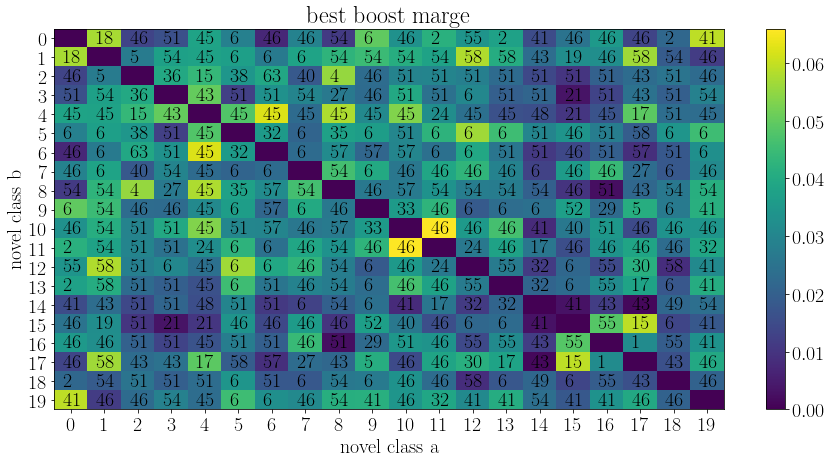

In [24]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmax_boost_pe_full,2),0), axis = 0)[0,:,:,0],aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmax_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('best boost marge')

Text(0.5, 1.0, 'best boost bruit')

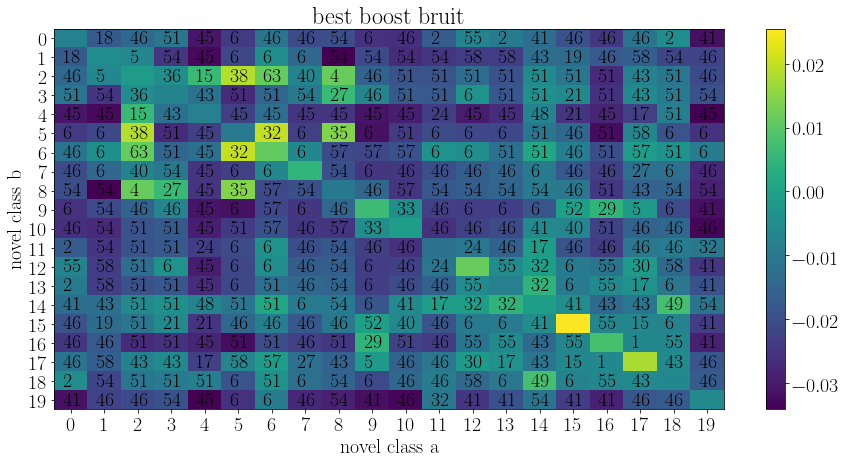

In [25]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmax_boost_pe_full,2),0), axis = 0)[0,:,:,1],aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmax_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('best boost bruit')

Text(0.5, 1.0, 'worst boost marge')

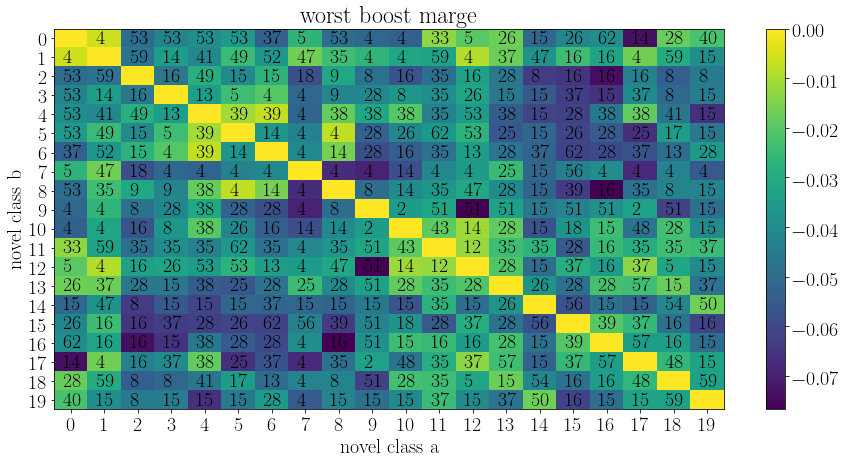

In [33]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmin_boost_pe_full,2),0), axis = 0)[0,:,:,0],aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmin_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('worst boost marge')

Text(0.5, 1.0, 'worst boost bruit')

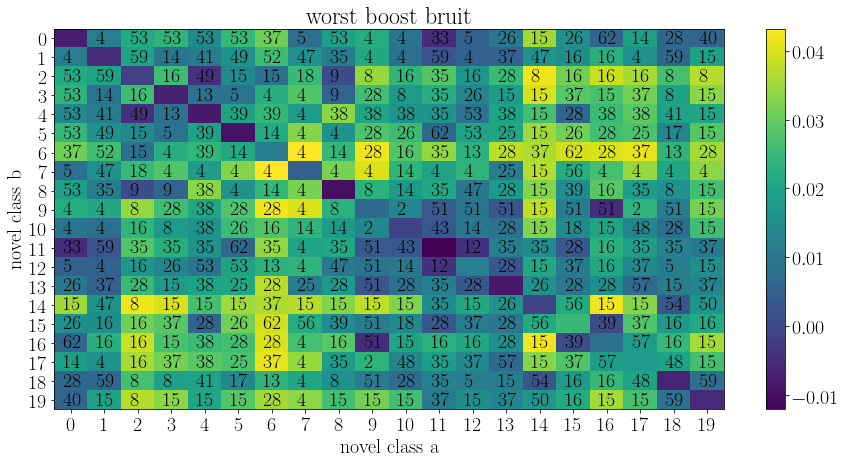

In [34]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmin_boost_pe_full,2),0), axis = 0)[0,:,:,1],aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmin_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('worst boost bruit')

In [28]:
baseline_marge = baseline_SNR_pe_full[:,:,0]
baseline_bruit = baseline_SNR_pe_full[:,:,1]

/tmp/ipykernel_433620/2339827442.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmax_boost_pe_full,2),0), axis = 0)[0,:,:,0]/baseline_marge*100,aspect='auto')


Text(0.5, 1.0, 'best boost relative marge change \\%')

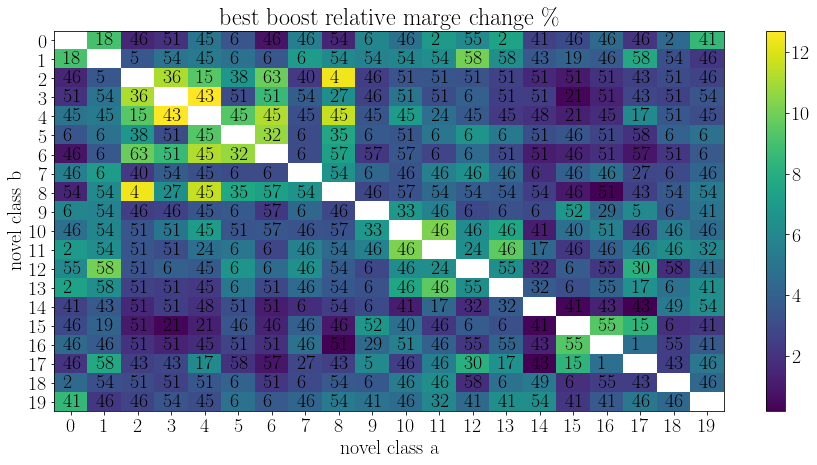

In [29]:
plt.figure(figsize=(15,7))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmax_boost_pe_full,2),0), axis = 0)[0,:,:,0]/baseline_marge*100,aspect='auto')
nb_novel = 20
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmax_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('best boost relative marge change \%')

Text(0.5, 1.0, 'best boost relative noise change \\%')

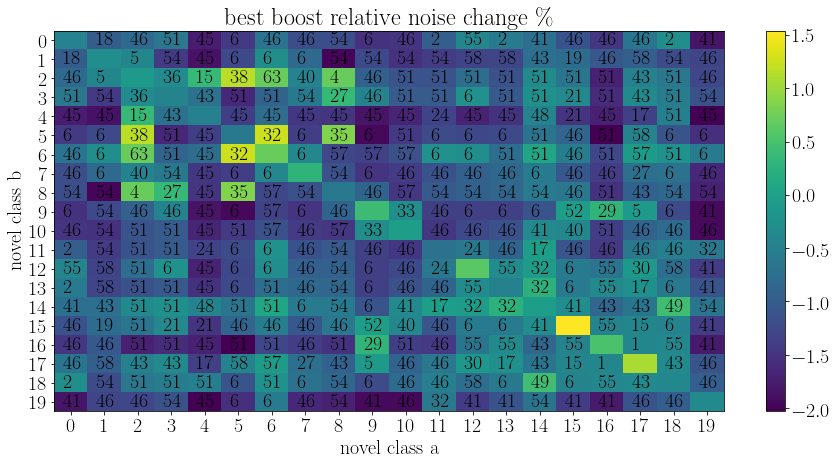

In [30]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmax_boost_pe_full,2),0), axis = 0)[0,:,:,1]/baseline_bruit*100,aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmax_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('best boost relative noise change \%')

/tmp/ipykernel_433620/3084864784.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmin_boost_pe_full,2),0), axis = 0)[0,:,:,0]/baseline_marge*100,aspect='auto')


Text(0.5, 1.0, 'worst boost relative marge change \\%')

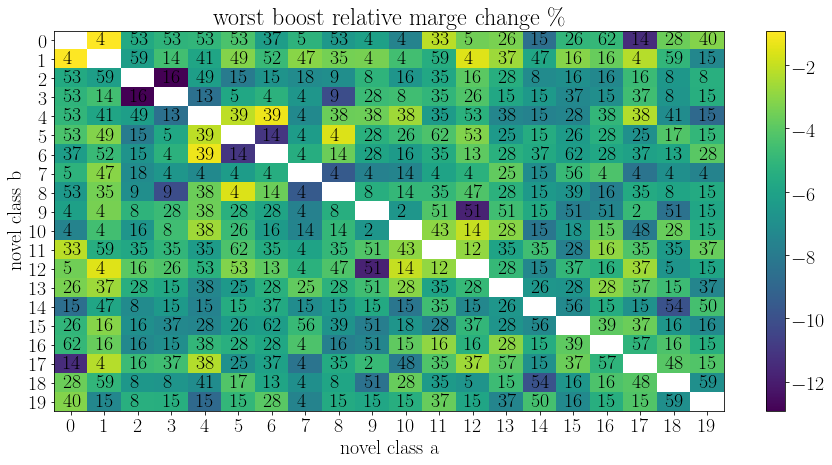

In [31]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))

plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmin_boost_pe_full,2),0), axis = 0)[0,:,:,0]/baseline_marge*100,aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmin_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('worst boost relative marge change \%')

Text(0.5, 1.0, 'worst boost relative noise change \\%')

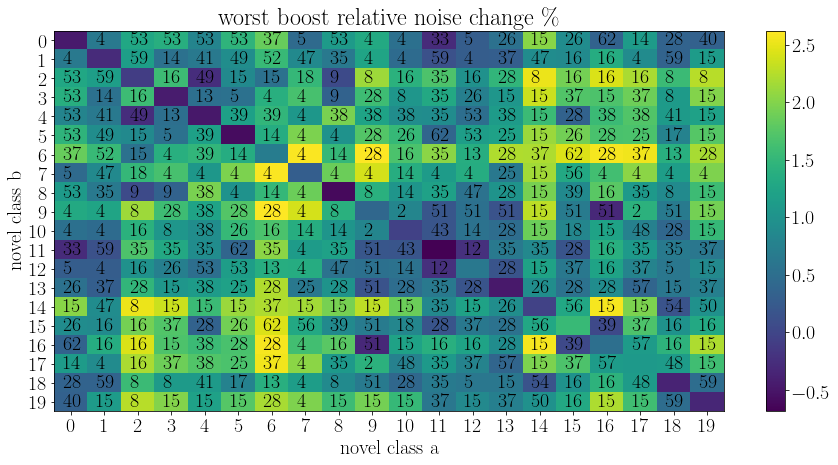

In [32]:
plt.figure(figsize=(15,7))
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    'font.size'   : 20
})
plt.xticks(np.arange(0, nb_novel, 1))
plt.yticks(np.arange(0, nb_novel, 1))
plt.imshow(np.take_along_axis(boost_pe_full, np.expand_dims(np.expand_dims(argmin_boost_pe_full,2),0), axis = 0)[0,:,:,1]/baseline_bruit*100,aspect='auto')
nb_novel = 20
shift_x, shift_y = -0.25, 0.25
for k in range(nb_novel):
    for l in range(nb_novel):
        if k!=l:
            plt.text(k+shift_x,l+shift_y,str(argmin_boost_pe_full[k,l]))
plt.colorbar()
plt.xlabel('novel class a')
plt.ylabel('novel class b')
#plt.savefig('best_snr.pdf')
#tikzplotlib.save('best.tikz')
plt.title('worst boost relative noise change \%')